In [1]:
from src.analytical_upperbound import eps2_upper_bound
from src.exact_diagonalization import *
from src.fitting import *

%load_ext autoreload
%autoreload 2

In [2]:
# It runs really fast O(n)
sigma=0.5

L=50000

J = sample_J_normal(L, sigma)
h = critical_h_from_J(J)
ub = eps2_upper_bound(J, h, num_splits=10)

np.log(ub)

np.float64(-63.61250003337003)

In [ ]:
# numerical experiments

import numpy as np
import pandas as pd
from tqdm import tqdm

# ----- sweep setup -----

for sigma in np.linspace(0.01, 0.5, 50):
    Ls = np.unique(np.round(np.linspace(50, 50000, 1000)).astype(np.int64))  # ensure unique ints
    n_per_L = 100

    rows = []  # will become a DataFrame

    for L in tqdm(Ls):
        for _ in range(n_per_L):
            J = sample_J_normal(L, sigma)
            h = critical_h_from_J(J)
            ub = eps2_upper_bound(J, h, num_splits=10)
            rows.append({"L": L, "eps2": ub})

    # ----- make DataFrame -----
    df = pd.DataFrame(rows).sort_values("L").reset_index(drop=True)

    # (optional) save for later use
    # df.to_csv("data/test_result_delta=1.00e-01.csv", index=False)

    # quick sanity check
    print(df.head())
    print(df.groupby("L")["eps2"].size().head())

    df.to_csv(f"data/UB_sigma={sigma:.2e}.csv")


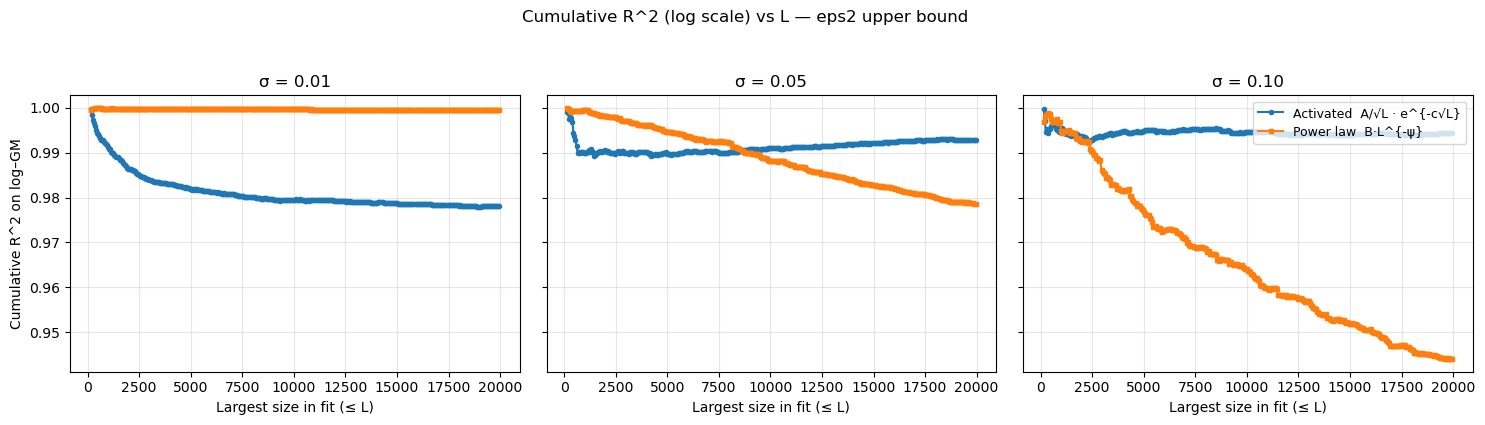

In [4]:

# ---------- load, compute, plot 1×3 ----------
sigmas = [0.01, 0.05, 0.10]
files = [f"data/UB_sigma={s:.2e}.csv" for s in sigmas]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for ax, sigma, fpath in zip(axes, sigmas, files):
    fpath = Path(fpath)
    if not fpath.exists():
        ax.text(0.5, 0.5, f"Missing:\n{fpath.name}", ha="center", va="center", fontsize=10)
        ax.set_axis_off()
        continue

    df = pd.read_csv(fpath)
    df = df[df["L"] <20000]
    tbl = log_mean_stats(df, "eps2")
    L  = tbl["L"].to_numpy()
    mu = tbl["mu"].to_numpy()
    se = tbl["se"].to_numpy()

    cum_df = cumulative_curves_r2(L, mu, se, min_pts=3, use_weights=False)

    ax.plot(cum_df["L"], cum_df["R2_activated_log"], marker="o", ms=3, label="Activated  A/√L · e^{-c√L}")
    ax.plot(cum_df["L"], cum_df["R2_powerlaw_log"],  marker="s", ms=3, label="Power law  B·L^{-ψ}")
    ax.set_title(f"σ = {sigma:.2f}")
    ax.set_xlabel("Largest size in fit (≤ L)")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Cumulative R^2 on log–GM")
axes[-1].legend(loc="upper right", fontsize=9)
fig.suptitle("Cumulative R^2 (log scale) vs L — eps2 upper bound", y=1.05, fontsize=12)
plt.tight_layout()
plt.show()


 sigma  L_star
  0.01 50000.0
  0.02 50000.0
  0.03 26600.0
  0.04 15250.0
  0.05  8550.0
  0.06  5450.0
  0.07  4250.0
  0.08  2200.0
  0.09  2200.0
  0.10  2250.0
  0.11   750.0
  0.12  1100.0
  0.13  1100.0
  0.14   750.0
  0.15   900.0
  0.16   700.0
  0.17   250.0
  0.18   400.0
  0.19   600.0
  0.20   200.0
  0.21     NaN
  0.22   400.0
  0.23     NaN
  0.24   150.0
  0.25     NaN
  0.26     NaN
  0.27     NaN
  0.28     NaN
  0.29   150.0
  0.30   200.0
  0.31     NaN
  0.32     NaN
  0.33   350.0
  0.34   150.0
  0.35     NaN
  0.36   150.0
  0.37     NaN
  0.38   300.0
  0.39   200.0
  0.40   250.0
  0.41   200.0
  0.42   150.0
  0.43     NaN
  0.44   200.0
  0.45   300.0
  0.46     NaN
  0.47     NaN
  0.48   150.0
  0.49     NaN
  0.50     NaN


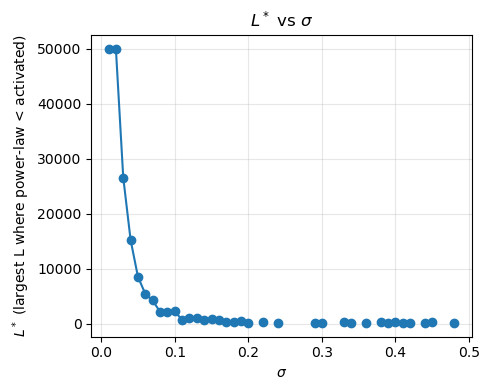

In [20]:
import re, glob


# ---------- sweep over available sigma files ----------
files = sorted(glob.glob("data/UB_sigma=*.csv"))
pat = re.compile(r"UB_sigma=([0-9.]+e[+-]\d+)\.csv$")

rows = []
for f in files:
    m = pat.search(Path(f).name)
    if not m:
        continue
    sigma = float(m.group(1))
    L_star = compute_L_star_for_file_r2(f, min_pts=3, use_weights=False)


    rows.append((sigma, L_star))

if not rows:
    raise RuntimeError("No matching files found in data/UB_sigma=*.csv")

res = pd.DataFrame(rows, columns=["sigma","L_star"]).sort_values("sigma").reset_index(drop=True)

# ---------- print table ----------
print(res.to_string(index=False))

# ---------- plot L* vs sigma ----------
plt.figure(figsize=(5,4))
plt.plot(res["sigma"], res["L_star"], marker="o")
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$L^*$ (largest L where power-law < activated)")
plt.title(r"$L^*$ vs $\sigma$")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


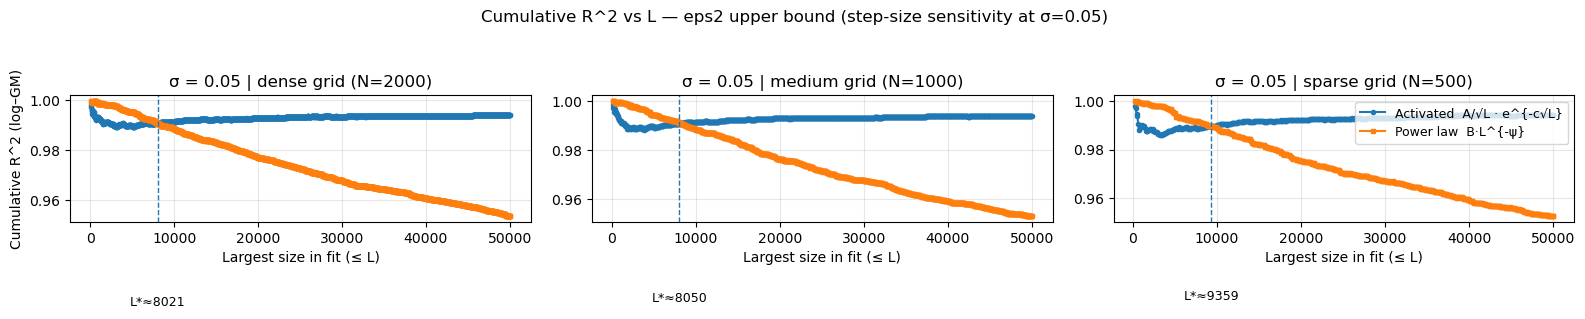

Saved figure to figures/Lstep_sensitivity_sigma0p05.png


In [22]:
import os
from tqdm import tqdm
# --- L-step sensitivity experiment for sigma=0.05 ---
# Runs three L-grids (2000 / 1000 / 500 points) and plots a 1x3 comparison.
# Assumes: sample_J_normal, critical_h_from_J, eps2_upper_bound already defined.

os.makedirs("data", exist_ok=True)
os.makedirs("figures", exist_ok=True)

SIGMA = 0.05
N_PER_L = 100      # keep consistent with your earlier runs
num_splits = 10   # for eps2_upper_bound

# ---------- sweep runner for one grid ----------
def run_sweep_for_grid(Ls, sigma, n_per_L, num_splits, out_path):
    out_path = Path(out_path)
    if out_path.exists():
        # already computed
        return

    rows = []
    for L in tqdm(Ls, desc=f"σ={sigma:.3f} | N_L={len(Ls)}"):
        for _ in range(n_per_L):
            J = sample_J_normal(int(L), sigma)
            h = critical_h_from_J(J)
            ub = eps2_upper_bound(J, h, num_splits=num_splits)
            rows.append({"L": int(L), "eps2": float(ub)})

    df = pd.DataFrame(rows).sort_values("L").reset_index(drop=True)
    df.to_csv(out_path, index=False)

# ---------- define the three grids ----------
def make_L_grid(npts):
    return np.unique(np.round(np.linspace(50, 50000, npts)).astype(np.int64))

GRIDS = [
    ("dense",   2000),
    ("medium",  1000),   # reference (your original step size)
    ("sparse",   500),
]

csv_paths = []
for tag, npts in GRIDS:
    Ls = make_L_grid(npts)
    csv = f"data/UB_sigma={SIGMA:.2e}_N{npts:04d}.csv"
    run_sweep_for_grid(Ls, SIGMA, N_PER_L, num_splits, csv)
    csv_paths.append((tag, npts, csv))

# ---------- plot 1x3 (independent y-axes) ----------
fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=False)

for ax, (tag, npts, csv) in zip(axes, csv_paths):
    df = pd.read_csv(csv)
    tbl = log_mean_stats(df, "eps2")
    L  = tbl["L"].to_numpy()
    mu = tbl["mu"].to_numpy()
    se = tbl["se"].to_numpy()

    cum_df = cumulative_curves_r2(L, mu, se, min_pts=3, use_weights=False)
    Lstar  = estimate_L_star_r2(cum_df)

    ax.plot(cum_df["L"], cum_df["R2_activated_log"], marker="o", ms=3, lw=1.5, label="Activated  A/√L · e^{-c√L}")
    ax.plot(cum_df["L"], cum_df["R2_powerlaw_log"],  marker="s", ms=3, lw=1.5, label="Power law  B·L^{-ψ}")

    # vertical line at L*
    ax.axvline(Lstar, linestyle="--", linewidth=1)
    ax.text(Lstar, ax.get_ylim()[1]*0.92, f"L*≈{int(Lstar)}", ha="center", va="top", fontsize=9)

    ax.set_title(f"σ = {SIGMA:.2f} | {tag} grid (N={npts})")
    ax.set_xlabel("Largest size in fit (≤ L)")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Cumulative R^2 (log–GM)")
axes[-1].legend(loc="upper right", fontsize=9)
fig.suptitle("Cumulative R^2 vs L — eps2 upper bound (step-size sensitivity at σ=0.05)", y=1.05, fontsize=12)
plt.tight_layout()
plt.savefig("figures/Lstep_sensitivity_sigma0p05.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved figure to figures/Lstep_sensitivity_sigma0p05.png")


Running independent experiments for ΔL in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] with joblib (backend='loky', n_jobs=-1)


ΔL grids:   0%|          | 0/10 [04:37<?, ?it/s]



Summary (per ΔL):
   DeltaL   Lstar  n_points                                    csv
0      10  8510.0      1995  data/UB_sigma=5.00e-02_DeltaL=010.csv
1      20  8030.0       998  data/UB_sigma=5.00e-02_DeltaL=020.csv
2      30  8540.0       665  data/UB_sigma=5.00e-02_DeltaL=030.csv
3      40  8730.0       499  data/UB_sigma=5.00e-02_DeltaL=040.csv
4      50  8750.0       399  data/UB_sigma=5.00e-02_DeltaL=050.csv
5      60  8690.0       333  data/UB_sigma=5.00e-02_DeltaL=060.csv
6      70  8520.0       285  data/UB_sigma=5.00e-02_DeltaL=070.csv
7      80  8690.0       250  data/UB_sigma=5.00e-02_DeltaL=080.csv
8      90  7340.0       222  data/UB_sigma=5.00e-02_DeltaL=090.csv
9     100  9550.0       200  data/UB_sigma=5.00e-02_DeltaL=100.csv


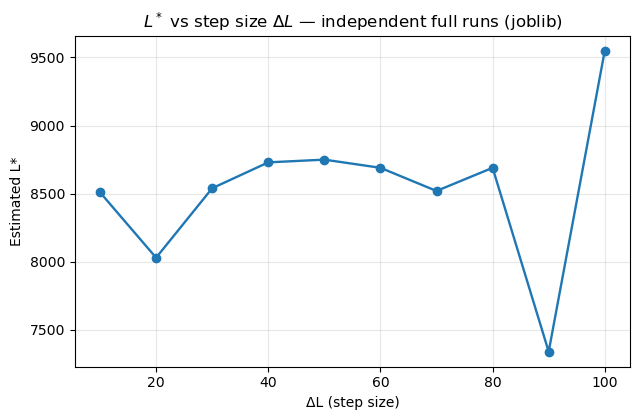


Saved figure to figures/Lstar_vs_DeltaL_traditional_joblib.png


In [13]:
# Traditional full-run experiment per ΔL (no data reuse) + joblib parallelism
# Requires your existing functions:
#   sample_J_normal, critical_h_from_J, eps2_upper_bound,
#   log_mean_stats, cumulative_curves_r2, estimate_L_star_r2

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

# ---------------- configuration ----------------
SIGMA       = 0.05
N_PER_L     = 100        # keep consistent with earlier runs
NUM_SPLITS  = 10         # for eps2_upper_bound
L_MIN       = 50
L_MAX       = 19990      # strictly < 20000
DELTA_LS    = list(range(10, 101, 10))  # 20,30,...,100

N_JOBS      = -1         # use all cores (tune if you like)
BACKEND     = "loky"     # separate processes (safe for CPU-bound)
BASE_SEED   = 123456789  # reproducible across ΔL grids

os.makedirs("data", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# ------------------- helpers -------------------
def grid_from_step(Lmin, Lmax, step):
    arr = np.arange(Lmin, Lmax + 1, step, dtype=np.int64)
    return arr[(arr >= Lmin) & (arr <= Lmax)]

def csv_path_for_delta(deltaL):
    return f"data/UB_sigma={SIGMA:.2e}_DeltaL={deltaL:03d}.csv"

def compute_Lstar_from_df(df):
    tbl = log_mean_stats(df, "eps2")
    L   = tbl["L"].to_numpy()
    mu  = tbl["mu"].to_numpy()
    se  = tbl["se"].to_numpy()
    cum_df = cumulative_curves(L, mu, se, min_pts=3, use_weights=False)
    Lstar  = estimate_L_star(cum_df)
    return float(Lstar)

def simulate_grid(deltaL):
    """
    Full, fresh simulation for one ΔL grid (independent of others).
    Returns a dict with DeltaL, Lstar, n_points, csv path.
    """
    csv_path = csv_path_for_delta(deltaL)
    if Path(csv_path).exists():
        df = pd.read_csv(csv_path)
        return {"DeltaL": deltaL, "Lstar": compute_Lstar_from_df(df),
                "n_points": df["L"].nunique(), "csv": csv_path}

    Ls = grid_from_step(L_MIN, L_MAX, deltaL)
    rows = []

    # local RNG per grid; also set deterministic seeds per (L,rep)
    rng = np.random.default_rng(BASE_SEED ^ (deltaL * 0x9E3779B1))

    for L in Ls:
        for rep in range(N_PER_L):
            # deterministic per-sample seed for fully reproducible grids
            seed = (BASE_SEED ^ (deltaL * 1315423911) ^ (int(L) * 2654435761) ^ rep) & 0xFFFFFFFF
            np.random.seed(seed)
            J = sample_J_normal(int(L), SIGMA)
            h = critical_h_from_J(J)
            ub = eps2_upper_bound(J, h, num_splits=NUM_SPLITS)
            rows.append({"L": int(L), "eps2": float(ub)})

    df = pd.DataFrame(rows).sort_values("L").reset_index(drop=True)
    df.to_csv(csv_path, index=False)

    return {"DeltaL": deltaL, "Lstar": compute_Lstar_from_df(df),
            "n_points": len(Ls), "csv": csv_path}

# ------------------- driver --------------------
print(f"Running independent experiments for ΔL in {DELTA_LS} with joblib (backend='{BACKEND}', n_jobs={N_JOBS})")

# Progress bar integration for joblib
with tqdm(tqdm(total=len(DELTA_LS), desc="ΔL grids")):
    results = Parallel(n_jobs=N_JOBS, backend=BACKEND)(
        delayed(simulate_grid)(dL) for dL in DELTA_LS
    )

res = pd.DataFrame(results).sort_values("DeltaL").reset_index(drop=True)
print("\nSummary (per ΔL):")
print(res)

# Plot L* vs ΔL
fig_path = "figures/Lstar_vs_DeltaL_traditional_joblib.png"
plt.figure(figsize=(6.5, 4.3))
plt.plot(res["DeltaL"], res["Lstar"], marker="o", ms=6, lw=1.7)
plt.xlabel("ΔL (step size)")
plt.ylabel("Estimated L*")
plt.title(r"$L^*$ vs step size $\Delta L$ — independent full runs (joblib)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(fig_path, dpi=200, bbox_inches="tight")
plt.show()
print(f"\nSaved figure to {fig_path}")




In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# -----------------------------
# Input from your message
# -----------------------------
Ls = np.array([
    25, 100, 225, 400, 625, 900, 1225, 1600, 2025, 2500,
    3025, 3600, 4225, 4900, 5625, 6400, 7225, 8100, 9025, 10000,
    11025, 12100, 13225, 14400, 15625, 16900, 18225, 19600, 21025, 22500,
    24025, 25600, 27225, 28900, 30625, 32400, 34225, 36100, 38025, 40000,
    42025, 44100, 46225, 48400, 50625, 52900, 55225, 57600, 60025, 62500
], dtype=np.int64)

ub_other = np.array([
    4.548757229895761811e-01, 3.451217464139075264e-02, 2.302450121633031754e-02, 1.148721845393226894e-03,
    7.923068694074836785e-07, 3.047885299404573221e-07, 1.339701536108984658e-08, 6.914434799651442980e-14,
    8.188875427605180372e-14, 1.141838336274087797e-13, 2.417372323732154221e-12, 4.649446248680409433e-12,
    1.154687126121100176e-11, 9.455493696183659514e-13, 2.524419821098530910e-12, 3.651165371803919352e-12,
    1.746080615929482053e-12, 2.458818204095719530e-36, 1.081517562300555043e-39, 9.068955099257063954e-40,
    1.137953473156112491e-52, 1.671830560656959284e-53, 3.166556345585948056e-55, 8.668082998309795095e-56,
    7.620535801942258398e-56, 1.244070359309479164e-56, 1.529338546529947249e-52, 1.894934072106351392e-55,
    1.061784531407298781e-55, 3.367726445991542881e-56, 9.429117226012433473e-56, 2.243870034411562589e-56,
    2.966064112310107998e-56, 3.825202474547351822e-55, 7.443750436839150458e-55, 1.302222581107938128e-56,
    3.785609811215274626e-56, 8.687503504172920429e-56, 3.069924487366237289e-55, 3.007223633459133760e-56,
    1.684938410999282963e-62, 6.651475830874080153e-63, 2.523787119498741351e-65, 2.512723464703074510e-68,
    8.080553420598467165e-70, 1.162811036040080219e-72, 5.217821853601944517e-72, 5.598415657299588259e-68,
    5.378092133496001951e-71, 3.229118077993179280e-70
], dtype=float)

assert Ls.shape[0] == ub_other.shape[0]

# -----------------------------
# Helper to build J_i = sin(i*sin(i))
# -----------------------------
def J_sin_sin(L: int) -> np.ndarray:
    # J has length L-1
    i = np.arange(1, L, dtype=np.float64)
    return np.sin(i * np.sin(i))

# -----------------------------
# Run your method on the same L grid
# Requires your functions: critical_h_from_J, eps2_upper_bound
# -----------------------------
our_ub = []
logs_other = np.log(ub_other)
for L in Ls:
    J = J_sin_sin(L)
    h = critical_h_from_J(J)             # <-- your function
    ub = eps2_upper_bound(J, h, num_splits="sweep", nd_ratio="sweep", dd_ratio="sweep")  # <-- your function/signature
    our_ub.append(ub)

our_ub = np.array(our_ub, dtype=float)
logs_our = np.log(our_ub)

# -----------------------------
# Build comparison table
# -----------------------------
df = pd.DataFrame({
    "L": Ls,
    "sqrtL": np.sqrt(Ls),
    "ub_other": ub_other,
    "ub_our": our_ub,
    "log_ub_other": logs_other,
    "log_ub_our": logs_our,
})
df["log_diff"] = df["log_ub_our"] - df["log_ub_other"]
df["ratio_our_over_other"] = df["ub_our"] / df["ub_other"]

# -----------------------------
# Error metrics (log-space is natural here)
# -----------------------------
def rmse(x):
    x = np.asarray(x, float)
    return float(np.sqrt(np.mean(np.square(x))))

rmse_log = rmse(df["log_diff"].values)
median_abs_log = float(np.median(np.abs(df["log_diff"].values)))
max_abs_log = float(np.max(np.abs(df["log_diff"].values)))

print("=== Comparison (J_i = sin(i*sin(i))) ===")
print(f"N points: {len(df)}")
print(f"RMSE in log-space: {rmse_log:.6g}")
print(f"Median |log diff|: {median_abs_log:.6g}")
print(f"Max |log diff|: {max_abs_log:.6g}")

# Show a few rows
with pd.option_context("display.max_rows", 12, "display.width", 120):
    print(df.head(10).to_string(index=False))

# -----------------------------
# Plots
# -----------------------------

# 1) sqrt(L) vs log(ub)
plt.figure()
plt.plot(df["sqrtL"].values, df["log_ub_other"].values, label="log(ub_other)")
plt.plot(df["sqrtL"].values, df["log_ub_our"].values, label="log(ub_our)")
plt.xlabel(r"$\sqrt{L}$")
plt.ylabel(r"$\log(\mathrm{upper\ bound})$")
plt.title("Upper bound comparison on J_i = sin(i sin i)")
plt.legend()
plt.tight_layout()
plt.show()

# 2) sqrt(L) vs log-difference
plt.figure()
plt.plot(df["sqrtL"].values, df["log_diff"].values)
plt.axhline(0.0)
plt.xlabel(r"$\sqrt{L}$")
plt.ylabel("log(ub_our) - log(ub_other)")
plt.title("Log-space difference (our method minus other)")
plt.tight_layout()
plt.show()

# 3) Scatter: other vs our in log space (useful to see alignment)
plt.figure()
plt.scatter(df["log_ub_other"].values, df["log_ub_our"].values, s=12)
mn = float(np.min([df["log_ub_other"].min(), df["log_ub_our"].min()]))
mx = float(np.max([df["log_ub_other"].max(), df["log_ub_our"].max()]))
plt.plot([mn, mx], [mn, mx])
plt.xlabel("log(ub_other)")
plt.ylabel("log(ub_our)")
plt.title("Parity plot in log-space")
plt.tight_layout()
plt.show()
